**STAT 685: Dr. Suojin Wang’s Group**

Modeling Seoul Bike Sharing Demand - 003 XGBoosting Study considering Time

Bai Zou, Nam Tran

# Key Takeaways
* Comparing with model assuming independent observation, using anchor date in model training and testing shows a lower performance.
* Information related to time of the year is missing in model training data when an anchor date is set. 
* Adding time related attributes has limited improvement.
* Next step:
    * More parameter tuning (Baseline performance is lower than referred literature)
    * Study effect with different anchor day setting and prediction horizon. E.g., predict last few days hourly demand by end of the season; predict next few hours demand in a random day by knowing all information before; etc.

# Data Process
* Load data and check data format
* Add dummy variables and convert qualitative variable to quantitative
* Randomly select 25% data as testing data

In [1]:
from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import time
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
## load data
fn = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), './data/SeoulBikeData.csv'))
colNames = ["Date", "RentedBikeCount", "Hour", "Temp", "Humidity", "WindSpeed", "Visibility", 
            "DewPointTemp", "SolarRadiation","Rainfall", "Snowfall", "Seasons", "Holiday", "FunctionalDay"]
dat = pd.read_csv(fn, encoding="ISO-8859-1")
dat.columns = colNames
dat = dat.astype(
    {"Date": str, 
    "RentedBikeCount": int, 
    "Hour": float, 
    "Temp": float, 
    "Humidity": float,
    "WindSpeed": float, 
    "Visibility": float, 
    "DewPointTemp": float, 
    "SolarRadiation": float,
    "Rainfall": float, 
    "Snowfall": float, 
    "Seasons": str, 
    "Holiday": str, 
    "FunctionalDay": str})

# convert qualitative variable to quantitative
dat = pd.get_dummies(dat, columns=["Seasons"])
del dat['Seasons_Winter']
dat = pd.get_dummies(dat, columns=["Holiday"])
del dat['Holiday_Holiday']
dat = pd.get_dummies(dat, columns=["FunctionalDay"])
del dat['FunctionalDay_Yes']
dat.shape

(8760, 16)

In [4]:
dat.head(2)

,Date,RentedBikeCount,Hour,Temp,Humidity,WindSpeed,Visibility,DewPointTemp,SolarRadiation,Rainfall,Snowfall,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Holiday_No Holiday,FunctionalDay_No
0,01/12/2017,254,0.0,-5.2,37.0,2.2,2000.0,-17.6,0.0,0.0,0.0,0,0,0,1,0
1,01/12/2017,204,1.0,-5.5,38.0,0.8,2000.0,-17.6,0.0,0.0,0.0,0,0,0,1,0


In [5]:
# split data into X and y
X = dat.iloc[:, 2:dat.shape[1]]
Y = dat.iloc[:,1]
print(f"X size {X.shape} and Y size {Y.shape}")

X size (8760, 14) and Y size (8760,)


# Model Assuming Independent Observations
* Training and Testing data are selected randomly across the year.
* The 'Date" information is not used.

In [6]:
# split data into train and test sets
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [7]:
print(f"X_train size {X_train.shape}; y_train size {y_train.shape}")

X_train size (6570, 14); y_train size (6570,)


In [8]:
print(f"X_test size {X_test.shape}; y_test size {y_test.shape}")

X_test size (2190, 14); y_test size (2190,)


## Simple XGBoost Model

* To start with, simply train the model with all training set from previous splitting.
* The training set prediction accuracy reaches 99.997 % but testing accuracy is at 85.487 %.
* The testing ressult is not improving after several iterations.
* The next step is to add CV and tune some parameters


In [45]:
%%capture
# fit model with training data
start_time = time.time()
model1 = xgb.XGBRegressor(n_estimators=1000)
model1.fit(X_train, y_train, 
           eval_set=[(X_train, y_train), (X_test, y_test)], 
           verbose=True)

In [46]:
print(f"Model running for {(time.time()-start_time)/60:0.2f} min.")

Model running for 0.04 min.


In [47]:
evals_result1 = model1.evals_result()

In [48]:
def plot_validation(evals_result, metric='rmse', ax=None, title=None):
    train_rmse = evals_result['validation_0'][metric]
    test_rmse = evals_result['validation_1'][metric]
    plot_dat = pd.DataFrame({'train_rmse': train_rmse, 
                            'test_rmse': test_rmse})
    title = f"{metric} by iterations" if title is None else title
    plot_dat.plot(xlabel="iterations", ylabel=metric, ax=ax, title=title)

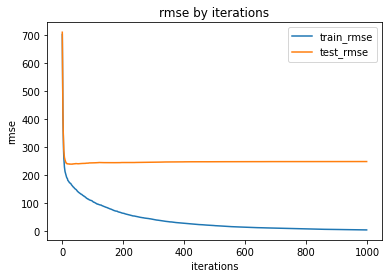

In [49]:
plot_validation(evals_result1)

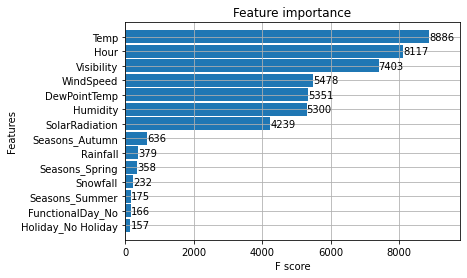

In [232]:
_ = xgb.plot_importance(model1, height=0.9)

In [145]:
score = model1.score(X_train, y_train)  
print(f"Training score: {score*100:.3f} %")

Training score: 99.997 %


In [146]:
score = model1.score(X_test, y_test)  
print(f"Testing score: {score*100:.3f} %")

Testing score: 85.487 %


## Model with GridSearchCV

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [279]:
%%capture
start_time = time.time()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, .07, 0.3], #so called `eta` value
              'max_depth': [3, 5, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        parameters,
                        cv = 10,
                        n_jobs = 5,
                        verbose=True)
model2 = xgb_grid.fit(X_train, y_train, 
                      eval_set=[(X_train, y_train), (X_test, y_test)], 
                      verbose=True)
model2 = model2.best_estimator_

In [284]:
print(f"Model running for {(time.time()-start_time)/60:0.2f} min.")

Model running for 2.48 min.


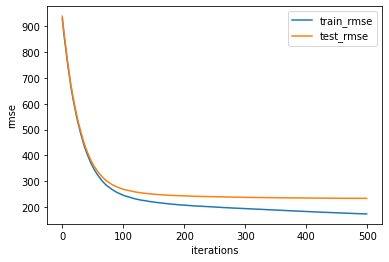

In [285]:
evals_result2 = model2.evals_result()
plot_validation(evals_result2)

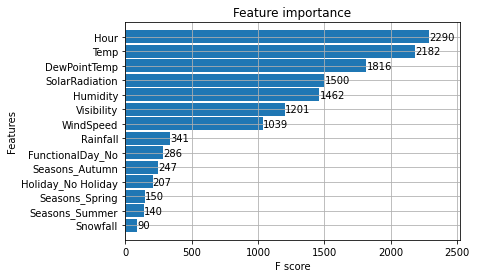

In [286]:
_ = xgb.plot_importance(model2, height=0.9)

In [287]:
score = model2.score(X_train, y_train)  
print(f"Training score: {score*100:.3f} %")

Training score: 92.766 %


In [288]:
score = xgb_grid.cv_results_['mean_test_score'].mean()
print(f"CV mean test score: {score*100:.3f} %")

CV mean test score: 86.589 %


In [289]:
score = model2.score(X_test, y_test)  
print(f"Testing score: {score*100:.3f} %")

Testing score: 87.148 %


# Model Tested with Anchor Date
* In this time series data, an anchor date is defined to split training and testing data.
* The model is trained based on data before anchor date and used to predict observations after anchor date to evaluate accuracy.
* Time series attribution is not included in this model.
* The testing results show:
    * In general lower accuracy compared with random testing data selection
    * The training data lacks information for season Autumn.
    * Non-function day attibute is not applied well based on prediction comparison plots. Non-function day record appears mainly during months 9, 10 and 11. Therefore, testing month 11 has the best prediction accuracy as month 9 and 10 information is included in training data.

## Training & Testing Data Splitting with Anchor Date
* In this time series data, observations are based by hour and date.
* 25% testing data equals to around 91 days or 3 months. 
* Split the data into 3 sets of training and testing data. 

In [21]:
dat['Date'] = pd.to_datetime(dat['Date'], format="%d/%m/%Y")

In [25]:
dat['Date'].dt.month.unique()

array([12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [115]:
dat_set = {}

for test_month in [9, 10, 11]:
    train_dat = dat[(dat['Date'].dt.month < test_month)|(dat['Date'].dt.year == 2017)]
    test_dat = dat[dat['Date'].dt.month == test_month]
    print(f"Training Data Size {train_dat.shape}; Testing Data Size {test_dat.shape}")
    sub_X_train = train_dat.iloc[:, 2:train_dat.shape[1]]
    sub_Y_train = train_dat.iloc[:,1]
    sub_X_test = test_dat.iloc[:, 2:test_dat.shape[1]]
    sub_Y_test = test_dat.iloc[:,1]
    dat_set[test_month] = (sub_X_train, sub_Y_train, sub_X_test, sub_Y_test)

Training Data Size (6576, 16); Testing Data Size (720, 16)
Training Data Size (7296, 16); Testing Data Size (744, 16)
Training Data Size (8040, 16); Testing Data Size (720, 16)


## Model Training and Testing

In [97]:
def cv_xgb_train(X_training, Y_training, X_testing, Y_testing):
    param = {'nthread':[4], #when use hyperthread, xgboost may become slower
                  'objective':['reg:squarederror'],
                  'learning_rate': [.03, .07, 0.3], #so called `eta` value
                  'max_depth': [3, 5, 7],
                  'min_child_weight': [4],
                  'silent': [1],
                  'subsample': [0.7],
                  'colsample_bytree': [0.7],
                  'n_estimators': [500]}

    x_g = GridSearchCV(xgb.XGBRegressor(),
                       param,
                       cv = 10,
                       n_jobs = 5,
                       verbose=True)
    mod = x_g.fit(X_training, 
                  Y_training,
                  eval_set=[(X_training, Y_training), (X_testing, Y_testing)],
                  verbose=True)
    mod = mod.best_estimator_
    return mod, x_g

In [98]:
%%capture
start_time = time.time()
res_summary = {}
res_mod = {}
for k, v in dat_set.items():
    sub_X_train, sub_Y_train, sub_X_test, sub_Y_test = v
    fit_mod, trained_grid = cv_xgb_train(sub_X_train, sub_Y_train, sub_X_test, sub_Y_test)
    # track mod
    res_mod[k] = fit_mod
    # track metric 
    res_summary[k] = {}
    res_summary[k]['train_score'] = fit_mod.score(sub_X_train, sub_Y_train)  
    res_summary[k]['mean_cv_score'] = trained_grid.cv_results_['mean_test_score'].mean()
    res_summary[k]['test_score'] = fit_mod.score(sub_X_test, sub_Y_test) 

In [100]:
print(f"Model running for {(time.time()-start_time)/60:0.2f} min.")

Model running for 7.92 min.


In [99]:
pd.DataFrame.from_dict(res_summary)

,9,10,11
train_score,0.933605,0.928365,0.924187
mean_cv_score,0.624540,0.628203,0.622360
test_score,0.775022,0.606972,0.763277


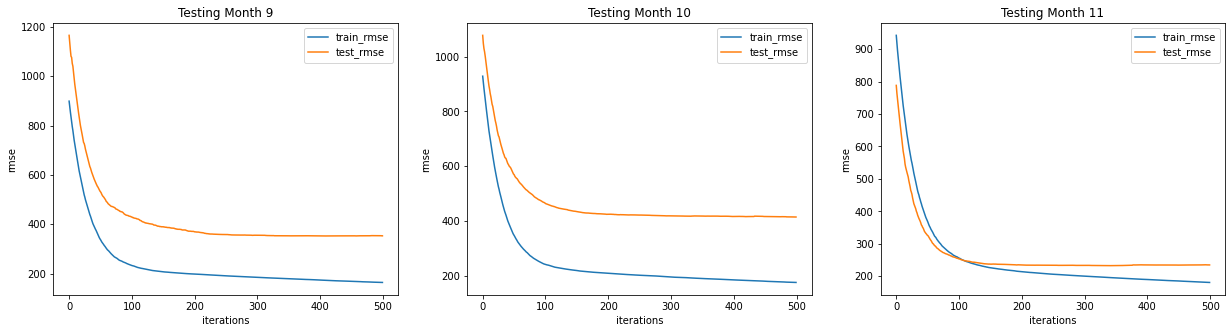

In [101]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,5))
for k, mod in res_mod.items():
    evals_res = mod.evals_result()
    plot_validation(evals_res, metric='rmse', ax=ax[k-9], title=f"Testing Month {k}")

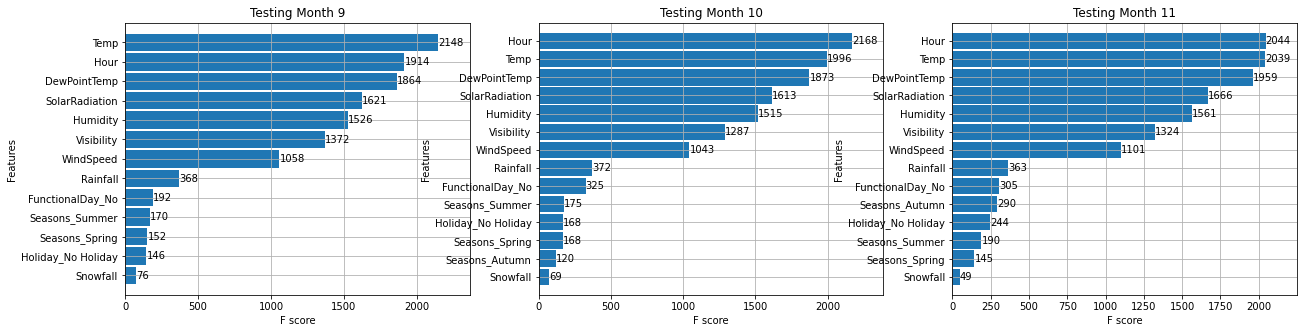

In [102]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,5))
for k, mod in res_mod.items():
    xgb.plot_importance(mod, height=0.9, ax=ax[k-9], title=f"Testing Month {k}")

## Prediction Accuracy by Time

In [107]:
def plot_prediction(mod, sub_X_test, sub_Y_test, ax=None, title=None):
    y_pred = mod.predict(sub_X_test)
    plot_dat = pd.DataFrame({"Predicted_Y_Teset":y_pred, 
                          "Recorded_Y_Teset": sub_Y_test})
    plot_dat.plot(xlabel="time", ylabel="count", ax=ax, title=title)

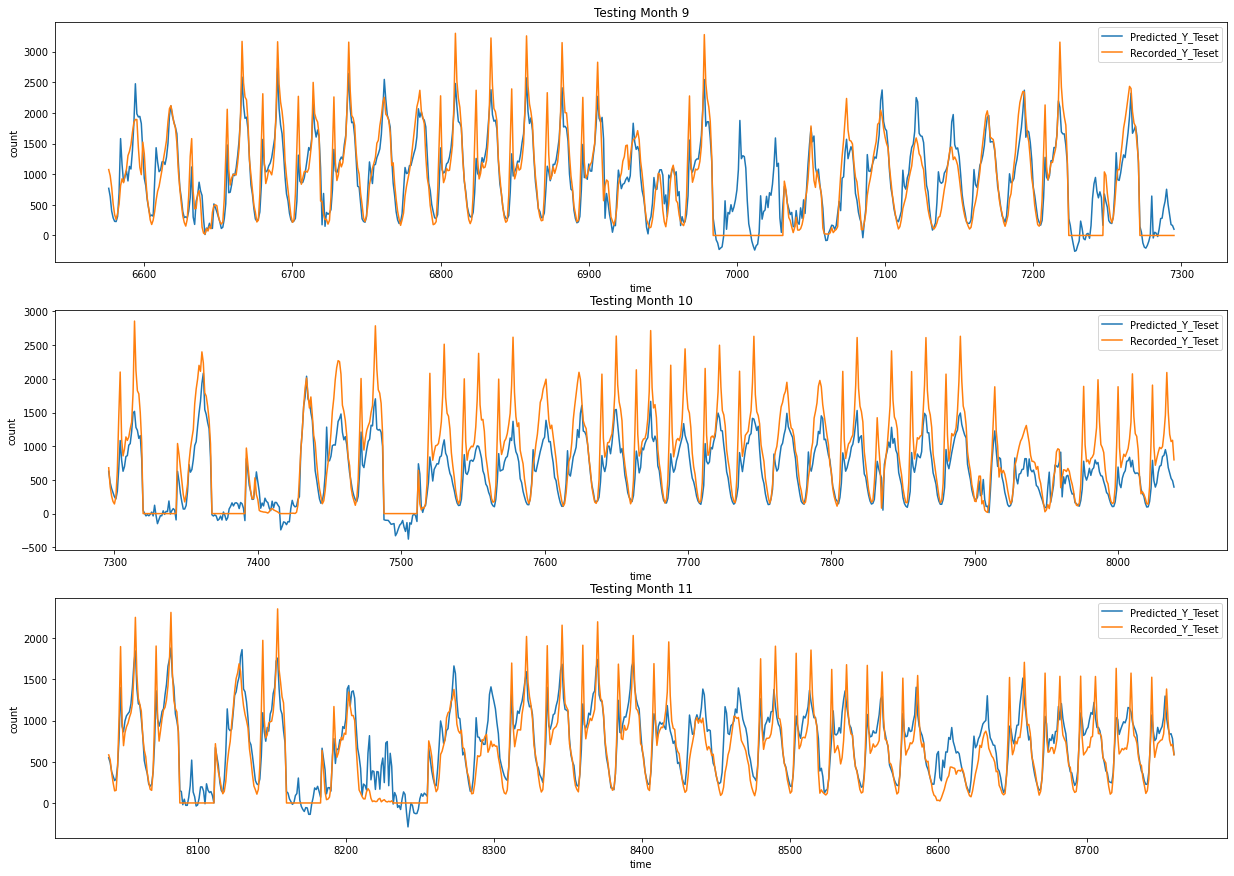

In [118]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(21,15))
for k, mod in res_mod.items():
    sub_X_train, sub_Y_train, sub_X_test, sub_Y_test = dat_set[k]
    plot_prediction(mod, sub_X_test, sub_Y_test, ax=ax[k-9], title=f"Testing Month {k}")

## Non-function Days
The plots above show a bad prediction on non-function days in month 9. By checking the non-function days across overall data:
* 2 days before September 2018
* 4 days in September 2018
* 4 days in October 2018
* 3 days in November 2018

In [138]:
dat.groupby('FunctionalDay_No').agg({'Date':'nunique'})

,Date
FunctionalDay_No,
0,353
1,13


In [139]:
dat[dat['FunctionalDay_No']==1]['Date'].unique()

array(['2018-04-11T00:00:00.000000000', '2018-05-10T00:00:00.000000000',
       '2018-09-18T00:00:00.000000000', '2018-09-19T00:00:00.000000000',
       '2018-09-28T00:00:00.000000000', '2018-09-30T00:00:00.000000000',
       '2018-10-02T00:00:00.000000000', '2018-10-04T00:00:00.000000000',
       '2018-10-06T00:00:00.000000000', '2018-10-09T00:00:00.000000000',
       '2018-11-03T00:00:00.000000000', '2018-11-06T00:00:00.000000000',
       '2018-11-09T00:00:00.000000000'], dtype='datetime64[ns]')

## Model Detail

In [155]:
for k, mod in res_mod.items():
    print(f"Testing month {k}: \n{mod}")

Testing month 9: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             silent=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)
Testing month 10: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             

# Model with Time Attributes
* There's some improvements in testing but along with slightly overfitting in training data.
* The added attributes ranked in the mid range in importance plots. Temp and Hour are still the two most important attributes.

In [121]:
dat2 = dat.copy()
dat2['Year'] = dat2['Date'].dt.year
dat2['Month'] = dat2['Date'].dt.month
dat2['Week'] = dat2['Date'].dt.week
dat2['Day'] = dat2['Date'].dt.day
dat2['DayOfWeek'] = dat2['Date'].dt.dayofweek

<ipython-input-121-1012b0438a4f>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dat2['Week'] = dat2['Date'].dt.week


In [122]:
dat2.head(2)

,Date,RentedBikeCount,Hour,Temp,Humidity,WindSpeed,Visibility,DewPointTemp,SolarRadiation,Rainfall,...,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Holiday_No Holiday,FunctionalDay_No,Year,Month,Week,Day,DayOfWeek
0,2017-12-01,254,0.0,-5.2,37.0,2.2,2000.0,-17.6,0.0,0.0,...,0,0,0,1,0,2017,12,48,1,4
1,2017-12-01,204,1.0,-5.5,38.0,0.8,2000.0,-17.6,0.0,0.0,...,0,0,0,1,0,2017,12,48,1,4


In [123]:
dat_set2 = {}

for test_month in [9, 10, 11]:
    train_dat = dat2[(dat2['Date'].dt.month < test_month)|(dat2['Date'].dt.year == 2017)]
    test_dat = dat2[dat2['Date'].dt.month == test_month]
    print(f"Training Data Size {train_dat.shape}; Testing Data Size {test_dat.shape}")
    sub_X_train = train_dat.iloc[:, 2:train_dat.shape[1]]
    sub_Y_train = train_dat.iloc[:,1]
    sub_X_test = test_dat.iloc[:, 2:test_dat.shape[1]]
    sub_Y_test = test_dat.iloc[:,1]
    dat_set2[test_month] = (sub_X_train, sub_Y_train, sub_X_test, sub_Y_test)

Training Data Size (6576, 21); Testing Data Size (720, 21)
Training Data Size (7296, 21); Testing Data Size (744, 21)
Training Data Size (8040, 21); Testing Data Size (720, 21)


In [156]:
def cv_xgb_train2(X_training, Y_training, X_testing, Y_testing):
    param = {'nthread':[4], #when use hyperthread, xgboost may become slower
                  'objective':['reg:squarederror'],
                  'learning_rate': [.03, .07, 0.3], #so called `eta` value
                  'max_depth': [3, 5],  # limiting max_depth to avoid overfitting
                  'min_child_weight': [4],
                  'silent': [1],
                  'subsample': [0.7],
                  'colsample_bytree': [0.7],
                  'n_estimators': [500]}

    x_g = GridSearchCV(xgb.XGBRegressor(),
                       param,
                       cv = 10,
                       n_jobs = 5,
                       verbose=True)
    mod = x_g.fit(X_training, 
                  Y_training,
                  eval_set=[(X_training, Y_training), (X_testing, Y_testing)],
                  verbose=True)
    mod = mod.best_estimator_
    return mod, x_g

In [157]:
%%capture
start_time = time.time()
res_summary2 = {}
res_mod2 = {}
for k, v in dat_set2.items():
    sub_X_train, sub_Y_train, sub_X_test, sub_Y_test = v
    fit_mod, trained_grid = cv_xgb_train2(sub_X_train, sub_Y_train, sub_X_test, sub_Y_test)
    # track mod
    res_mod2[k] = fit_mod
    # track metric 
    res_summary2[k] = {}
    res_summary2[k]['train_score'] = fit_mod.score(sub_X_train, sub_Y_train)  
    res_summary2[k]['mean_cv_score'] = trained_grid.cv_results_['mean_test_score'].mean()
    res_summary2[k]['test_score'] = fit_mod.score(sub_X_test, sub_Y_test) 

In [158]:
print(f"Model running for {(time.time()-start_time)/60:0.2f} min.")

Model running for 9.74 min.


In [159]:
pd.DataFrame.from_dict(res_summary2)  # TODO check negative values

,9,10,11
train_score,0.968569,0.964197,0.981632
mean_cv_score,0.687866,0.575854,-0.235344
test_score,0.799063,0.714356,0.825770


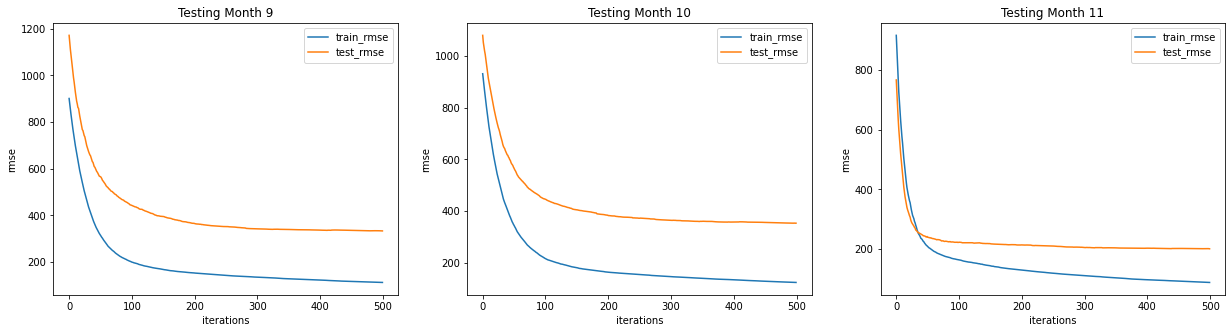

In [161]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,5))
for k, mod in res_mod2.items():
    evals_res = mod.evals_result()
    plot_validation(evals_res, metric='rmse', ax=ax[k-9], title=f"Testing Month {k}")

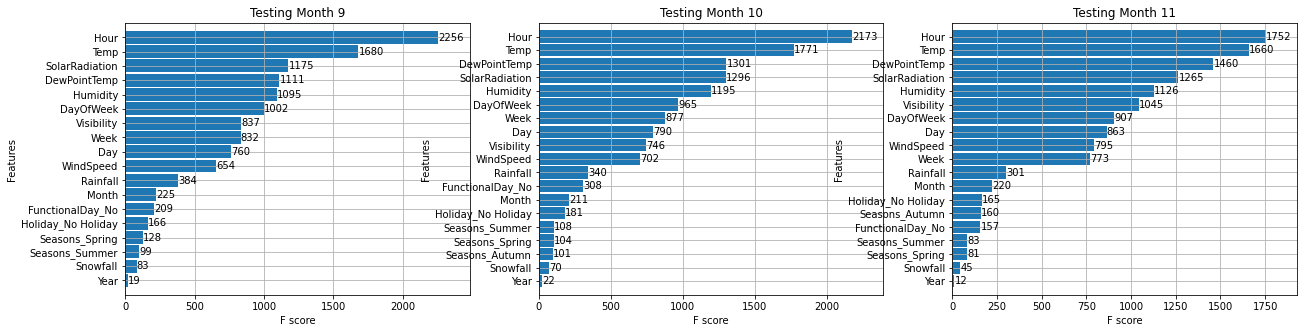

In [162]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21,5))
for k, mod in res_mod2.items():
    xgb.plot_importance(mod, height=0.9, ax=ax[k-9], title=f"Testing Month {k}")

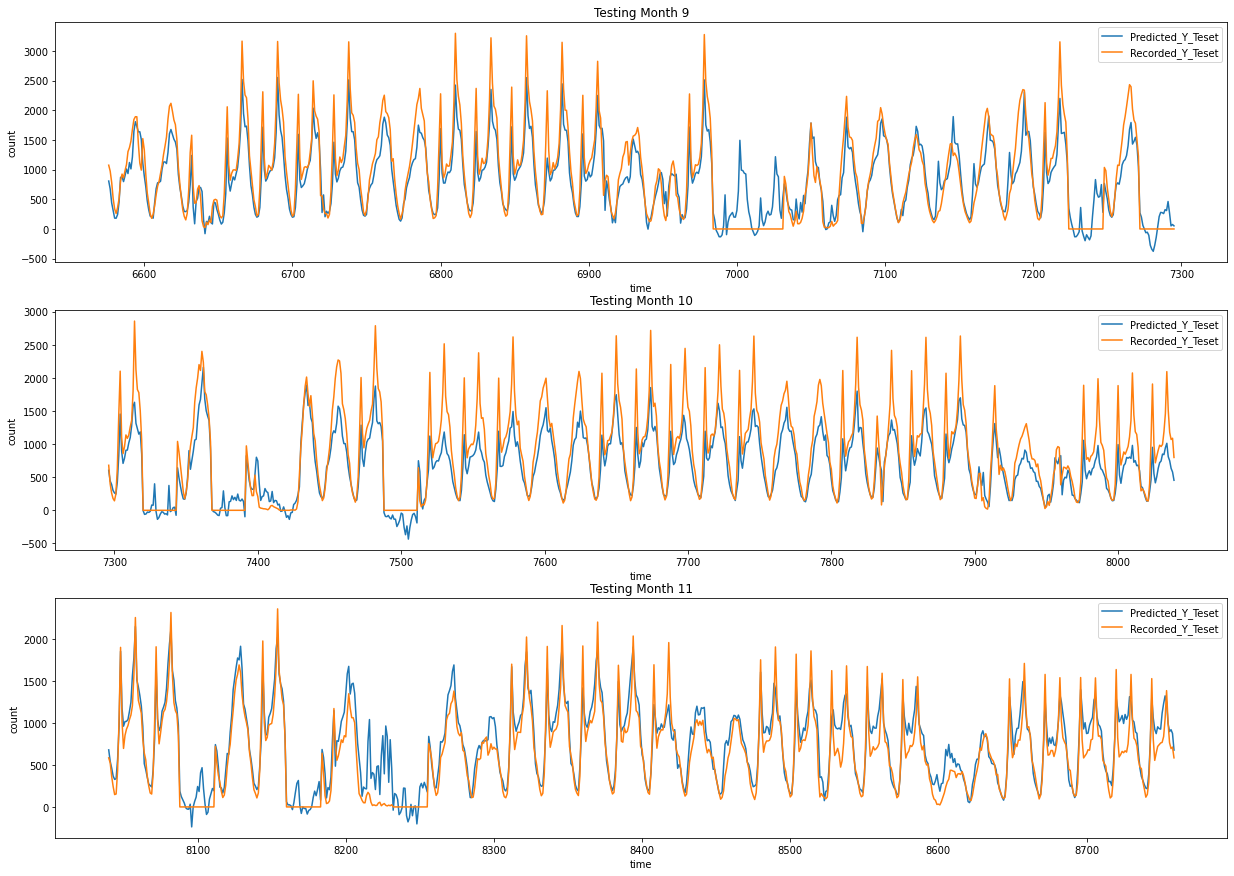

In [163]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(21,15))
for k, mod in res_mod2.items():
    sub_X_train, sub_Y_train, sub_X_test, sub_Y_test = dat_set2[k]
    plot_prediction(mod, sub_X_test, sub_Y_test, ax=ax[k-9], title=f"Testing Month {k}")

In [160]:
for k, mod in res_mod2.items():
    print(f"Testing month {k}: \n{mod}")

Testing month 9: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             silent=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)
Testing month 10: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             